In [50]:
import numpy as np
import matplotlib.pyplot as plt
import math
import columnas_utils as col
import pandas as pd
%matplotlib inline
%matplotlib notebook

## Diseño de columnas de Concreto Armado

In [51]:
# Definicion de las unidades
N = 1
m = 1
cm = 1/100
Pa = 1
MPa = 10**6
pulg = 2.54 / 100

# Definicion de varillas de acero:
d_3 = 3/8 * pulg
d_4 = 1/4 * pulg
d_5 = 5/8 * pulg
d_6 = 3/4 * pulg
d_8 = 1 * pulg

A_3 = d_3 ** 2 /4 * math.pi
A_4 = d_4 ** 2 /4 * math.pi
A_5 = d_5 ** 2 /4 * math.pi
A_6 = d_6 ** 2 /4 * math.pi
A_8 = d_8 ** 2 /4 * math.pi

### Datos de los materiales:

In [52]:
# Concreto
fc  = 21* MPa  #Resistencia a la compresion
eps_u = 0.003 #Deformación unitaria ultima

#Acero
fy = 420 * MPa #Esfuerzo a la fluencia del acero
Es = 200000 * MPa #Módulo de elasticidad del acero
eps_y = 0.0021 #Deformación de fluencia del acero


### Sección Transversal de la columna

In [53]:
b = 35 * cm
h = 75 * cm
r = 4 * cm #recubrimiento
Ag = b*h #Área bruta

#Refuerzo en la columna:
d_p = d_5 #diámetro principal
d_s = d_5 #diámetro secundario
d_st = d_3 #diámetro del estribo
n_f = 6 #filas de acero
n_c = 3 #columnas de acero

#Creando matriz de refuerzos:
reb_matx = col.create_rebar_matrix(d_p,d_s,n_f,n_c)

#Matriz y vecto de areas de refuerzos:
area_matx = reb_matx**2*math.pi/4
area_vect = area_matx.flatten()

#Área de acero
Aref = area_matx.sum()

#Creando vectores de distancias a las varillas de refuerzos
dist_vect_x = col.dist_vector(b, r, d_p, d_st,n_c)
dist_vect_y = col.dist_vector(h, r, d_p, d_st,n_f)

## Resistencia a la Compresión Pura

In [54]:
phi = 0.65 #factor de minoración
P_n = 0.85*fc*(Ag-Aref)+Aref*fy #Resistemcia Nominal
phiP_n = phi*0.8*P_n #Resistencia reducida
betha = col.def_betha(fc) #Factor de bloque equvalente de esfuerzos

In [55]:
phiP_n

3016002.7986698234

## Rango de Iteración

In [56]:
#Definiendo el ángulo de rotacion de columna con respecto a la vertical
theta = math.radians(90)
#Rango de iteracion de a (borde de la columna)
l = b*math.cos(theta)+h*math.sin(theta)
#Definiendo puntos de iteración
a = np.array([i/100*l for i in range(101)])
#Vectores de altura al eje neutro:
c = a/betha

## Aporte de las barras

In [57]:
#Vector de distancias de cada barra (paralelo a las distancias a)
dist_vect_x_rot = dist_vect_x*math.cos(theta)
dist_vect_y_rot = dist_vect_y*math.sin(theta)
dist_matx = np.array([i+dist_vect_x_rot for i in dist_vect_y_rot])
dist_vect = dist_matx.flatten()

In [58]:
#Esfuerzos en cada barra de refuerzo:
matx_fs = col.vector_function(col.vector_function,c,
                              col.stress_f,dist_vect,eps_u,Es,fy)

In [59]:
#distancia a las varillas extremas a tensión:
d_t = dist_vect.max()

#Valores de phi para cada valor de c
vect_phi = col.vector_function(col.def_phi,c,d_t,eps_u,eps_y)

In [60]:
#Aporte a la resistencia axial del acero:
rsp = np.dot(matx_fs,area_vect)

#Aporte a la resistencia de momento del acero:
dist_list_x = np.array([dist_vect_x for _ in dist_vect_y]).flatten()
dist_list_y = np.array([i for i in dist_vect_y for _ in dist_vect_x])
dist_CM_x = b/2-dist_list_x
dist_CM_y = h/2-dist_list_y
rsm_x = np.dot(matx_fs*area_vect,dist_CM_x)
rsm_y = np.dot(matx_fs*area_vect,dist_CM_y)

## Determinación de Fuerzas Resistentes

In [65]:
#Determinación del Area a compresion y su centroide:
A_X_Y = col.vector_function(col.comp_area,a,b,h,theta)
A_c = A_X_Y[:,0]
x_c = A_X_Y[:,1]
y_c = A_X_Y[:,2]

In [66]:
#Carga Axial Nominal
vect_Pn = col.vect_ax_force_n(A_c,rsp,fc)

#Carga Axial Reducida
vect_phi_Pn = vect_phi*vect_Pn
vect_phi_Pn = np.array([i if i < phiP_n else phiP_n for i in vect_phi_Pn])

In [67]:
#Momento nominal:
vect_Mn_x = col.vect_momentum_n(A_c,x_c,rsm_x,fc,b,theta)
vect_Mn_y = col.vect_momentum_n(A_c,y_c,rsm_y,fc,h,theta)

#Momento reducido:
vect_phi_Mn_x = vect_phi*vect_Mn_x
vect_phi_Mn_y = vect_phi*vect_Mn_y

## Graficas de Flexocompresión

<IPython.core.display.Javascript object>


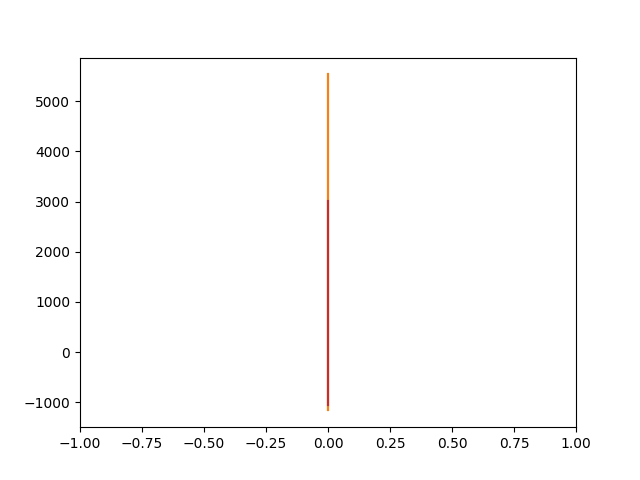

In [70]:
fig, ax = plt.subplots()
ax.plot(vect_Mn_x/10**6, vect_Pn/1000)
ax.plot(-vect_Mn_x/10**6, vect_Pn/1000)
ax.plot(vect_phi_Mn_x/10**6, vect_phi_Pn/1000)
ax.plot(-vect_phi_Mn_x/10**6, vect_phi_Pn/1000)
ax.set_xlim(-1, 1)
plt.show()

<IPython.core.display.Javascript object>


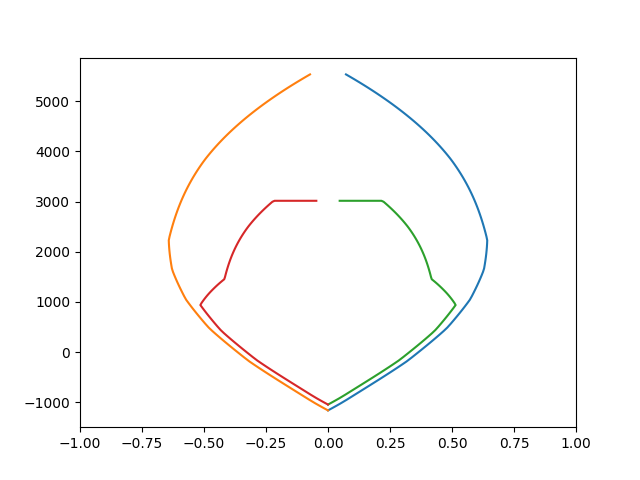

In [71]:
fig, ax = plt.subplots()
ax.plot(vect_Mn_y/10**6, vect_Pn/1000)
ax.plot(-vect_Mn_y/10**6, vect_Pn/1000)
ax.plot(vect_phi_Mn_y/10**6, vect_phi_Pn/1000)
ax.plot(-vect_phi_Mn_y/10**6, vect_phi_Pn/1000)
ax.set_xlim(-1, 1)
plt.show()

<IPython.core.display.Javascript object>


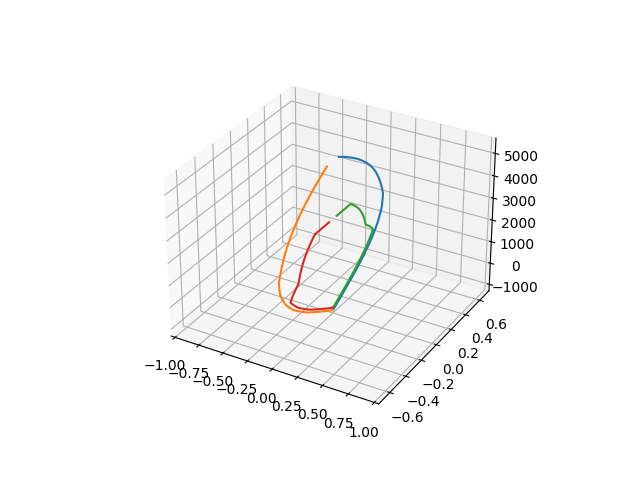

In [72]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)
ax.plot(vect_Mn_x/10**6,vect_Mn_y/10**6, vect_Pn/1000)
ax.plot(-vect_Mn_x/10**6,-vect_Mn_y/10**6, vect_Pn/1000)
ax.plot(vect_phi_Mn_x/10**6,vect_phi_Mn_y/10**6, vect_phi_Pn/1000)
ax.plot(-vect_phi_Mn_x/10**6,-vect_phi_Mn_y/10**6, vect_phi_Pn/1000)

## En una sóla función

In [35]:
d_conc = {'fc': 21*MPa,
          'eps_u':0.003}
d_steel = {'fy' : 420*MPa,
          'Es' : 200000*MPa,
          'eps_y' : 0.0021}
geom = {'b':35*cm,
       'h':75*cm,
       'r':4*cm}
steel = {'d_p' : d_5,
        'd_s' : d_5,
        'd_st' : d_3,
        'n_f' : 6,
        'n_c' : 3}

flex_comp_data = col.flex_comp_data(d_conc,d_steel,geom,steel,phi,theta=50)

vect_Pn = flex_comp_data[0]
vect_phi_Pn = flex_comp_data[1]
vect_Mn_x = flex_comp_data[2]
vect_Mn_y = flex_comp_data[3]
vect_phi_Mn_x = flex_comp_data[4]
vect_phi_Mn_y = flex_comp_data[5]

<IPython.core.display.Javascript object>


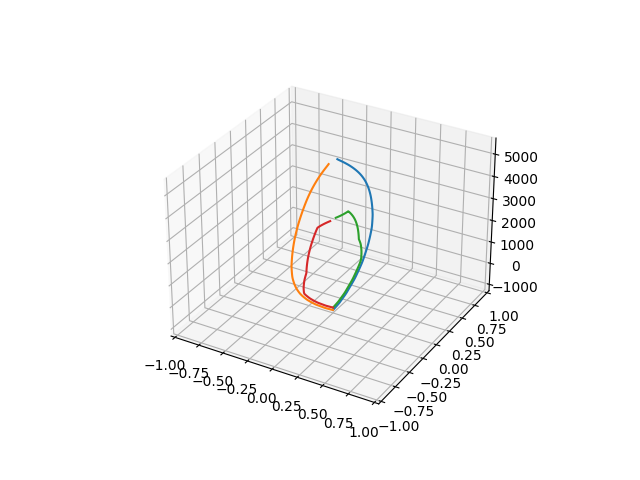

In [36]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)
ax.plot(vect_Mn_x/10**6,vect_Mn_y/10**6, vect_Pn/1000)
ax.plot(-vect_Mn_x/10**6,-vect_Mn_y/10**6, vect_Pn/1000)
ax.plot(vect_phi_Mn_x/10**6,vect_phi_Mn_y/10**6, vect_phi_Pn/1000)
ax.plot(-vect_phi_Mn_x/10**6,-vect_phi_Mn_y/10**6, vect_phi_Pn/1000)

## Gráfico de Flexocompresión Biaxial

In [37]:
theta = np.array(range(45))*2

flex_comp_data = col.vector_function(col.flex_comp_data,theta,
                                     d_conc,d_steel,geom,steel,phi)

Pn = flex_comp_data[:,0]
phi_Pn = flex_comp_data[:,1]
Mn_x = flex_comp_data[:,2]
Mn_y = flex_comp_data[:,3]
phi_Mn_x = flex_comp_data[:,4]
phi_Mn_y = flex_comp_data[:,5]

<IPython.core.display.Javascript object>


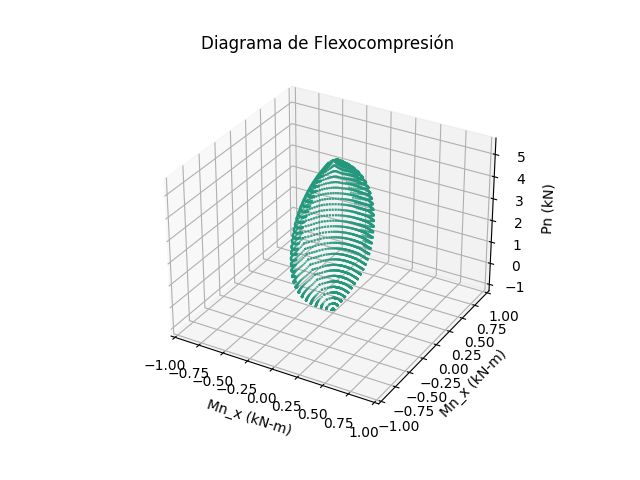

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
for i,theta_ in enumerate(theta):
    col.plot_flex_comp(Pn[i],Mn_x[i],Mn_y[i],ax)
    
plt.title('Diagrama de Flexocompresión')
ax.set_xlabel("Mn_x (kN-m)")
ax.set_ylabel("Mn_x (kN-m)")
ax.set_zlabel("Pn (kN)")

plt.show()

<IPython.core.display.Javascript object>


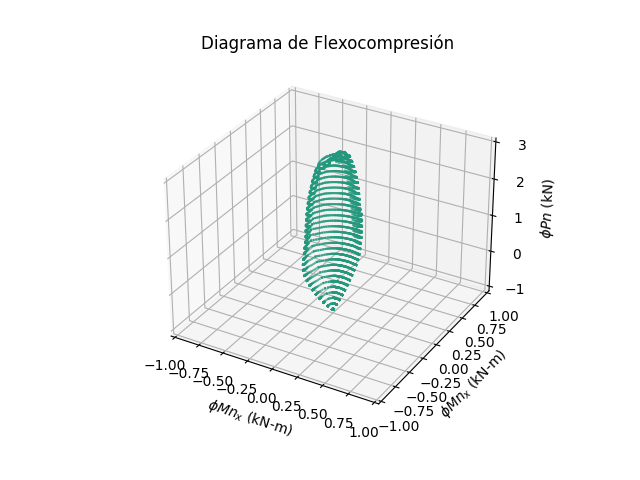

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
for i,theta_ in enumerate(theta):
    col.plot_flex_comp(phi_Pn[i],phi_Mn_x[i],phi_Mn_y[i],ax)
    
plt.title('Diagrama de Flexocompresión')
ax.set_xlabel("$\phi Mn_x$ (kN-m)")
ax.set_ylabel("$\phi Mn_x$ (kN-m)")
ax.set_zlabel("$\phi Pn$ (kN)")
plt.show()